In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import flopy

In [2]:
def rmse(sim, obs, locs):
    acc = 0.
    for loc in locs:
        diff = sim[loc] - obs[loc]
        acc += diff ** 2.
    return np.sqrt(acc / np.float(len(locs)))

In [3]:
# load the base model
bws = os.path.join('..', 'base')
m = flopy.modflow.Modflow.load('m.nam', version='mf2005', model_ws=bws, check=False)

In [4]:
# observation location
obs_locs = [(0,3,10),
            (0,3,16),
            (0,4,9),
            (0,10,2),
            (0,14,11),
            (0,16,17),
            (0,22,11),
            (0,23,16),
            (0,25,5),
            (0,27,7),
            (0,30,16),
            (0,34,8),
            (0,35,11),
            (0,39,8),
            (0,39,11),
            (0,39,13)]

In [5]:
# get list of active cells
active_locs = []
ib = m.bas6.ibound.array
for i in range(ib.shape[1]):
    for j in range(ib.shape[2]):
        if ib[0, i, j] > 0:
            active_locs.append((0, i, j))

In [6]:
# get list of pumping well locations
wels = m.wel.stress_period_data[1]
well_locs = []
for wel in wels:
    well_locs.append((wel['k'], wel['i'], wel['j']))

In [7]:
# get list of hk files
dpth = os.path.join('..', 'hk')
hk_files = [os.path.join(dpth, fn) for fn in sorted(os.listdir(dpth)) 
            if os.path.splitext(os.path.join(dpth, fn))[1] in ['.DAT', '.dat'] and 'GroupX' in fn]
hk_files

['../hk/GroupX_EX05_PEST.DAT']

In [8]:
# get list of calibration head files
dpth = os.path.join('..', 'calibration-heads')
calh_files = [os.path.join(dpth, fn) for fn in sorted(os.listdir(dpth)) if '.hds' in fn and 'GroupX' in fn]

In [9]:
# get list of predictive head files
dpth = os.path.join('..', 'predictive-heads')
predh_files = [os.path.join(dpth, fn) for fn in sorted(os.listdir(dpth)) if '.hds' in fn and 'GroupX' in fn]

In [10]:
# get list of particle files
dpth = os.path.join('..', 'particles')
part_files = [os.path.join(dpth, fn) for fn in sorted(os.listdir(dpth)) if '.ptl' in fn and 'GroupX' in fn]

In [11]:
# get true hk
hktrue = m.lpf.hk.array
hktrue[ib <= 0] = 1.
shape2d = hktrue[0, :, :].shape
shape3d = hktrue.shape

In [12]:
# get true calibration and predictive heads
fpth = os.path.join(bws, 'm.hds')
hobj = flopy.utils.HeadFile(fpth)
ch = hobj.get_data(totim=1.) 
ph = hobj.get_data(totim=2.)

In [13]:
print('Observation Wells - Hydraulic Conductivity')
print('{:5s}{:>20s}'.format('Group', 'RMSE'))
print(25*('-'))
for fpth in hk_files:
    sid = os.path.basename(fpth).split('_')[0].replace('Group', '')
    d = np.loadtxt(fpth)
    if d.shape != shape2d:
        d = flopy.utils.Util2d.load_txt(shape2d, fpth, fmtin='(10e15.6)', dtype=np.float32)
    d = d.reshape(shape3d)
    v = rmse(d, hktrue, obs_locs)
    print('{:5s}{:20g}'.format(sid, v))

Observation Wells - Hydraulic Conductivity
Group                RMSE
-------------------------
X                 4.92294


In [14]:
print('Active Cells - Hydraulic Conductivity')
print('{:5s}{:>20s}'.format('Group', 'RMSE'))
print(25*('-'))
for fpth in hk_files:
    sid = os.path.basename(fpth).split('_')[0].replace('Group', '')
    d = np.loadtxt(fpth)
    if d.shape != shape2d:
        d = flopy.utils.Util2d.load_txt(shape2d, fpth, fmtin='(10e15.6)', dtype=np.float32)
    d = d.reshape(shape3d)
    v = rmse(d, hktrue, active_locs)
    print('{:5s}{:20g}'.format(sid, v))

Active Cells - Hydraulic Conductivity
Group                RMSE
-------------------------
X                 6.38396


In [15]:
print('Observation Well - Calibration')
print('{:5s}{:>20s}'.format('Group', 'RMSE'))
print(25*('-'))
for fpth in calh_files:
    sid = os.path.basename(fpth).split('_')[0].replace('Group', '')
    hobj = flopy.utils.HeadFile(fpth)
    h = hobj.get_data()
    v = rmse(h, ch, obs_locs)
    print('{:5s}{:20g}'.format(sid, v))
    #rmseobs.append(rmse(h, calhtrue, active_locs))
    #rmsecalh.append(rmse(h, calhtrue, obs_locs))
    

Observation Well - Calibration
Group                RMSE
-------------------------
X             2.86668e-05


In [16]:
print('Active Cells - Calibration')
print('{:5s}{:>20s}'.format('Group', 'RMSE'))
print(25*('-'))
for fpth in calh_files:
    sid = os.path.basename(fpth).split('_')[0].replace('Group', '')
    hobj = flopy.utils.HeadFile(fpth)
    h = hobj.get_data()
    v = rmse(h, ch, active_locs)
    print('{:5s}{:20g}'.format(sid, v))

Active Cells - Calibration
Group                RMSE
-------------------------
X                0.490048


In [17]:
print('Observation Well - Prediction')
print('{:5s}{:>20s}'.format('Group', 'RMSE'))
print(25*('-'))
for fpth in predh_files:
    sid = os.path.basename(fpth).split('_')[0].replace('Group', '')
    hobj = flopy.utils.HeadFile(fpth)
    h = hobj.get_data()
    v = rmse(h, ph, obs_locs)
    print('{:5s}{:20g}'.format(sid, v))

Observation Well - Prediction
Group                RMSE
-------------------------
X               0.0499641


In [18]:
print('Pumping Well - Prediction')
print('{:5s}{:>20s}'.format('Group', 'RMSE'))
print(25*('-'))
for fpth in predh_files:
    sid = os.path.basename(fpth).split('_')[0].replace('Group', '')
    hobj = flopy.utils.HeadFile(fpth)
    h = hobj.get_data()
    v = rmse(h, ph, well_locs)
    print('{:5s}{:20g}'.format(sid, v))

Pumping Well - Prediction
Group                RMSE
-------------------------
X                 1.09346


In [19]:
print('Active Cells - Prediction')
print('{:5s}{:>20s}'.format('Group', 'RMSE'))
print(25*('-'))
for fpth in predh_files:
    sid = os.path.basename(fpth).split('_')[0].replace('Group', '')
    hobj = flopy.utils.HeadFile(fpth)
    h = hobj.get_data()
    v = rmse(h, ph, active_locs)
    print('{:5s}{:20g}'.format(sid, v))

Active Cells - Prediction
Group                RMSE
-------------------------
X                  0.4724


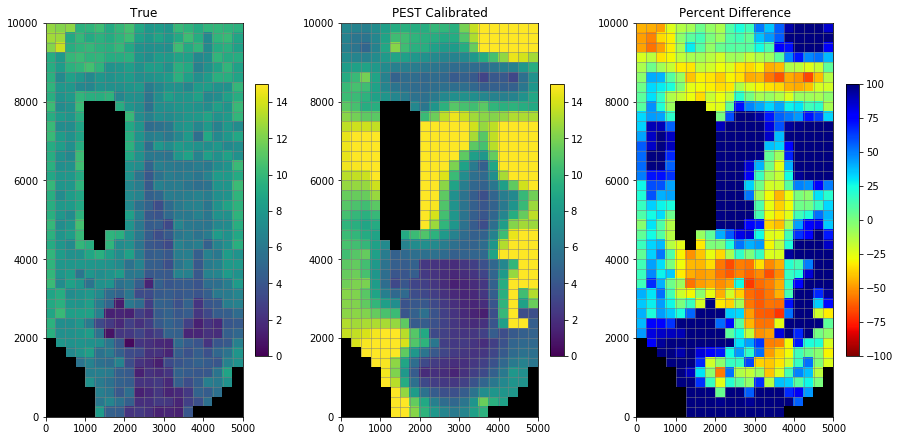

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 10))
axes = axes.flatten()

mmaps = []
for ax in axes:
    mm = flopy.plot.ModelMap(model=m, ax=ax)
    mmaps.append(mm)
    mm.plot_grid(lw=0.5, zorder=100)
    mm.plot_ibound(zorder=100)
    ax.set_aspect('equal')
    
ax = axes[0]
mm = mmaps[0]
v = mm.plot_array(m.lpf.hk.array, vmin=0, vmax=15, zorder=1)
ax.set_title('True')
plt.colorbar(v, shrink=0.5, ax=ax)

ax = axes[1]
mm = mmaps[1]
fpth = hk_files[0]
d = np.loadtxt(fpth)
if d.shape != shape2d:
    d = flopy.utils.Util2d.load_txt(shape2d, fpth, fmtin='(10e15.6)', dtype=np.float32)
v = mm.plot_array(d, vmin=0, vmax=15)
ax.set_title('PEST Calibrated')
plt.colorbar(v, shrink=0.5, ax=ax)

ax = axes[2]
mm = mmaps[2]
d = d.reshape(shape3d)
pd = 100. * (d - hktrue) / hktrue
pd[ib <= 0] = 0

v = mm.plot_array(pd, vmin=-100, vmax=100, cmap='jet_r')
ax.set_title('Percent Difference')
plt.colorbar(v, shrink=0.5, ax=ax);

In [21]:
fpth = os.path.join(bws, 'm.hds')
hobj = flopy.utils.HeadFile(fpth)
hcal = hobj.get_data(totim=1.)

In [22]:
fpth = calh_files[0]
hobj = flopy.utils.HeadFile(fpth)
h = hobj.get_data()

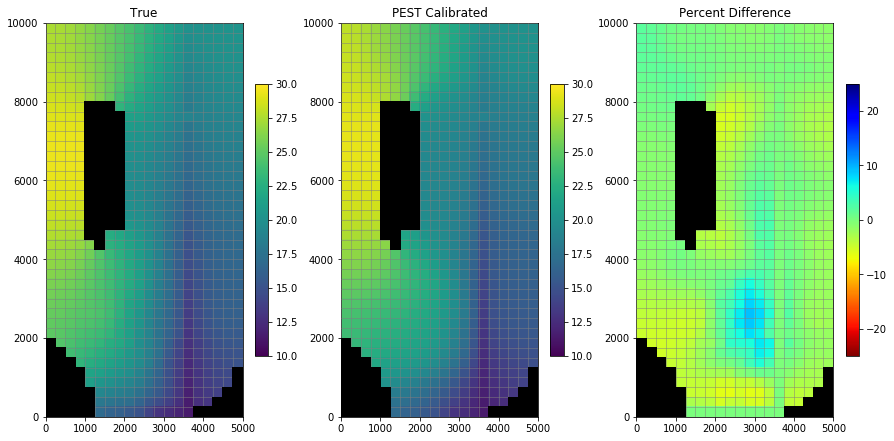

In [23]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 10))
axes = axes.flatten()

mmaps = []
for ax in axes:
    mm = flopy.plot.ModelMap(model=m, ax=ax)
    mmaps.append(mm)
    mm.plot_grid(lw=0.5, zorder=100)
    mm.plot_ibound(zorder=100)
    ax.set_aspect('equal')
    
ax = axes[0]
mm = mmaps[0]
v = mm.plot_array(hcal, vmin=10, vmax=30, masked_values=[999.0], zorder=1)
ax.set_title('True')
plt.colorbar(v, shrink=0.5, ax=ax)

ax = axes[1]
mm = mmaps[1]
v = mm.plot_array(h, vmin=10, vmax=30, masked_values=[999.0], zorder=1)
ax.set_title('PEST Calibrated')
plt.colorbar(v, shrink=0.5, ax=ax)

ax = axes[2]
mm = mmaps[2]
pd = 100. * (h - hcal) / hcal
pd[ib <= 0] = 0

v = mm.plot_array(pd, vmin=-25, vmax=25, cmap='jet_r')
ax.set_title('Percent Difference')
plt.colorbar(v, shrink=0.5, ax=ax);

In [24]:
fpth = os.path.join(bws, 'm.hds')
hobj = flopy.utils.HeadFile(fpth)
hprd = hobj.get_data(totim=2.)

In [25]:
fpth = predh_files[0]
hobj = flopy.utils.HeadFile(fpth)
h = hobj.get_data()

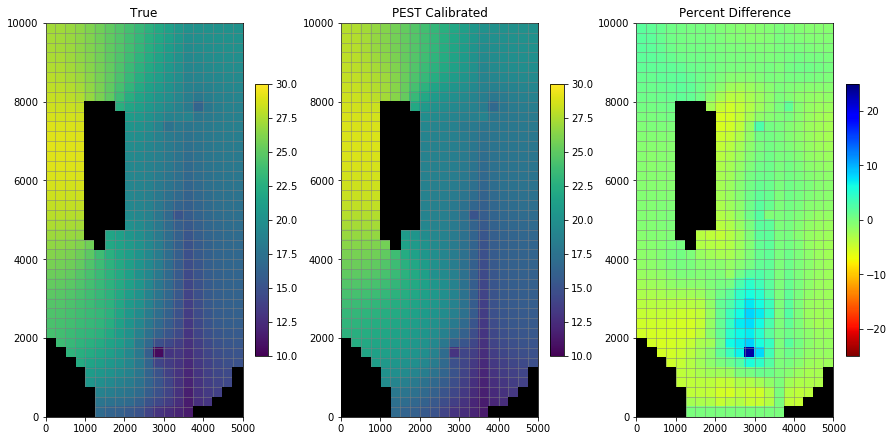

In [26]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 10))
axes = axes.flatten()

mmaps = []
for ax in axes:
    mm = flopy.plot.ModelMap(model=m, ax=ax)
    mmaps.append(mm)
    mm.plot_grid(lw=0.5, zorder=100)
    mm.plot_ibound(zorder=100)
    ax.set_aspect('equal')
    
ax = axes[0]
mm = mmaps[0]
v = mm.plot_array(hprd, vmin=10, vmax=30, masked_values=[999.0], zorder=1)
ax.set_title('True')
plt.colorbar(v, shrink=0.5, ax=ax)

ax = axes[1]
mm = mmaps[1]
v = mm.plot_array(h, vmin=10, vmax=30, masked_values=[999.0], zorder=1)
ax.set_title('PEST Calibrated')
plt.colorbar(v, shrink=0.5, ax=ax)

ax = axes[2]
mm = mmaps[2]
pd = 100. * (h - hprd) / hprd
pd[ib <= 0] = 0

v = mm.plot_array(pd, vmin=-25, vmax=25, cmap='jet_r')
ax.set_title('Percent Difference')
plt.colorbar(v, shrink=0.5, ax=ax);

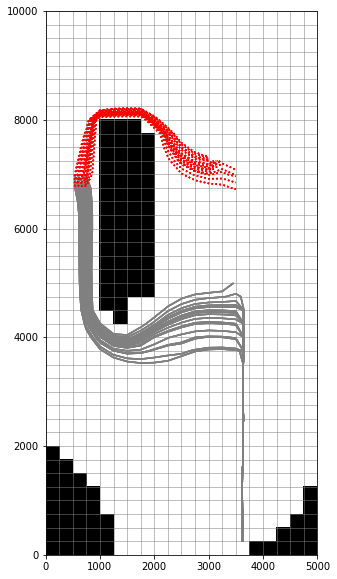

In [27]:
# pathline analysis
fpth = os.path.join(bws, 'm_mp.ptl')
pathtrue = flopy.utils.PathlineFile(fpth)
ptrue = pathtrue.get_alldata()

mm = flopy.plot.ModelMap(model=m)
fig = mm.ax.get_figure()
fig.set_figheight(10)
fig.set_figwidth(5)
mm.plot_grid(lw=0.5)
mm.plot_ibound()
for ppth in part_files:
    pobj = flopy.utils.PathlineFile(ppth)
    p = pobj.get_alldata()
    mm.plot_pathline(p, color='0.5')
    
#mm.plot_array(m.dis.botm.array)
mm.plot_pathline(ptrue, color='red', linestyle=':');